In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import root_mean_squared_error as rmse
import time
import tkinter as tk
from tkinter import messagebox
import math
import matplotlib as mpl
from scipy.spatial import ConvexHull

# our functions
import predict_Beta_I
import choice_start_day

import warnings
warnings.filterwarnings(action='ignore')

# to account for updates when files change
%load_ext autoreload
%autoreload 2

# Main programme

In [27]:
def plot_one(ax, 
             predicted_days, seed_df, predicted_I, 
             beggining_beta, predicted_beta,
             seed_number, execution_time):
    '''
    Plotting the graph for a seed.
    
    Parameters:

    - ax -- area for the plot
    - predicted_days -- predicted days
    - seed_df -- DataFrame of seed, created by the regular network
    - predicted_I -- predicted trajectory of the Infected compartment
    - beggining_beta -- predicted initial values of Beta
    - predicted_beta -- predicted values of Beta
    - seed_number -- seed number        
    - execution_time -- time taken to predict Beta   
    - median_values -- sample mean of predicted_I on a specific day
    - lower_bound -- upper boundary of the interval (3 standard deviations of predicted_I on a specific day)
    - upper_bound -- lower boundary of the interval (3 standard deviations of predicted_I on a specific day)
    '''

    # when shifting forecasts, sometimes NaN values appear here
    predicted_I[np.isnan(predicted_I)] = 0.0  
    predicted_beta[np.isnan(predicted_beta)] = 0.0
    beggining_beta[np.isnan(beggining_beta)] = 0.0
 
    # find the maximum and its index
    predicted_peak_I = max(predicted_I[0])
    predicted_peak_day = predicted_days[0] + np.argmax(predicted_I[0])
    actual_I = seed_df.iloc[:]['I'].values 
    actual_peak_I = max(actual_I)
    actual_peak_day = np.argmax(actual_I)+1

    peak = [actual_peak_I, predicted_peak_I,actual_peak_day,predicted_peak_day] 

    # calculate RMSE for Infected and Beta values
    actual_I = seed_df.iloc[predicted_days[0]:]['I'].values 
    rmse_I = rmse(actual_I, predicted_I[0])
    actual_Beta = seed_df.iloc[predicted_days[0]:]['Beta'].values 
    rmse_Beta = rmse(actual_Beta, predicted_beta)   

    # display boundary of switch 
    ax.axvline(predicted_days[0], color='red',ls=':')

    if predicted_I.shape[0] > 1:
        # display trajectories of the stochastic mathematical model
        for i in range(predicted_I.shape[0]-1):
            ax.plot(predicted_days, predicted_I[i+1], color='tab:orange', ls='--', 
                    alpha=0.3, label='Predicted I (stoch.)' if i == 0 else '')

        # median calculation
        median_values = np.median(predicted_I, axis=0) 
        # standard error
        std_dev = np.std(predicted_I, axis=0)
        # boundaries: median ± 3σ (checked for negative values)
        lower_bound = median_values - 3 * std_dev
        upper_bound = median_values + 3 * std_dev
        lower_bound = np.maximum(lower_bound, 0)
        # add vertical lines with tick marks for confidence intervals
        for day in range(0, len(predicted_days), 5): 
            ax.errorbar(predicted_days[day], median_values[day],
                        yerr=[[median_values[day] - lower_bound[day]], 
                            [upper_bound[day] - median_values[day]]], 
                        fmt='o', color='black', capsize=2, markersize=2, elinewidth=1, 
                        alpha=0.6, label='$\mu \pm 3\sigma$' if day == 0 else '')

    # display actual and predicted Infected values
    ax.plot(seed_df.index, seed_df.iloc[:]['I'].values , color='tab:blue', 
            label='Actual I')
    ax.plot(predicted_days, predicted_I[0],color='red', ls='-', 
              alpha=0.9, label='Predicted I (det.)')
    
    # add axis labels
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected')#, color='tab:blue')
    ax.grid(True, alpha=0.3)
        
    ax_b = ax.twinx()
    # display actual and predicted Beta values
    ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='-', 
              alpha=0.4, label='Actual Beta')

    if len(beggining_beta) > 0:
        given_days = np.arange(predicted_days[0])
        ax_b.plot(given_days, beggining_beta,color='green', ls='--', 
                  alpha=0.7)
    ax_b.plot(predicted_days, predicted_beta,color='green', ls='--', 
              alpha=0.7, label='Predicted Beta ')
    ax_b.set_ylabel("Beta")#, color='gray')

    # add legend and titles
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    leg = ax_b.legend(lines1 + lines2, labels1 + labels2, loc='upper right',
                    framealpha=1.0, fontsize=9)
    leg.set_zorder(100)
    leg.get_frame().set_facecolor('white')
    ax.set_title(f'Seed {seed_number}, Switch day {predicted_days[0]}\n'+
                 f'Peak I (act.):{actual_peak_I:.2f}, '+
                   f'Peak day (act.):{actual_peak_day:.2f}, \n' +
                 f'Peak I (pred.):{predicted_peak_I:.2f}, '+
                   f'Peak day (pred.):{predicted_peak_day:.2f}, \n' +
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Predict time: {execution_time:.2e}' ,fontsize=10)
    return rmse_I, rmse_Beta, peak

def main_f(I_prediction_method, stochastic, count_stoch_line, 
           beta_prediction_method, type_start_day, seed_numbers,
           show_fig_flag, ax = None, 
           features_reg = ['day','prev_I','S','E','I','R']):
    '''
    Main function
    
    Parameters:
    
    - I_prediction_method -- mathematical model for constructing the trajectory of Infected
        ['seir']
    - stochastic -- indicator of the presence of predicted stochastic trajectories of Infected 
    - count_stoch_line -- number of predicted stochastic trajectories of Infected 
    - beta_prediction_method -- method for predicting Beta values
        ['last_value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        'median beta',
        'regression (day)'
        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    - type_start_day -- type of choosing the switching day for the model 
        (changing or constant)
        ['roll_var',  
         'roll_var_seq', 
         'roll_var_npeople', 
         20,
         30,
         40]
    - seed_numbers -- seed numbers for the experiments
    - show_fig_flag -- flag to show the plots
    - save_fig_flag -- flag to save the plots
    
    Output:
        Graph for seeds.
    '''
     # setting always constant values for mathematical model parameters
    sigma = 0.1
    gamma = 0.08
    if ax is None:
        row_n = len(seed_numbers)//2+math.ceil(len(seed_numbers)%2)
        fig, axes = plt.subplots(row_n, 2, figsize=(15, 4*row_n))
        axes = axes.flatten()
    else:
        axes = ax
    
    # declaration of the folder with DataFrames of seeds created by the regular network
    seed_dirs='test/'
    print(beta_prediction_method)
    # list of RMSE Beta and I for each seed 
    all_rmse_I = []
    all_rmse_Beta = []
    all_peak = []
    start_days = []
    execution_time = []
    for idx, seed_number in enumerate(seed_numbers):
        print(seed_number)
        # read the DataFrame of the seed: S,[E],I,R,Beta
        seed_df = pd.read_csv(seed_dirs + f'{I_prediction_method}_seed_{seed_number}.csv')
        
        seed_df = seed_df[pd.notna(seed_df['Beta'])]

        # switch moment
        start_day = choice_start_day.choose_method(seed_df, type_start_day)
        start_days.append(start_day)
        # choosing the days for prediction
        predicted_days = np.arange(start_day, seed_df.shape[0])
        start_time = time.time()
        # prediction of Beta values and calculation of prediction time
        beggining_beta, predicted_beta, predicted_I = predict_Beta_I.predict_beta(
                            I_prediction_method, seed_df, beta_prediction_method, 
                            predicted_days, stochastic, count_stoch_line, sigma, gamma, features_reg)
        
        if (beta_prediction_method != 'regression (day, SEIR, previous I)') & (
            beta_prediction_method != 'lstm (day, E, previous I)'):
             # extract compartment values on the switch day
            y = seed_df.iloc[predicted_days[0]].drop('Beta')

            # predict the Infected compartment trajectory
            _,_,predicted_I[0],_ = predict_Beta_I.predict_I(I_prediction_method, y, 
                                    predicted_days, 
                                    predicted_beta, sigma, gamma, 'det')
            if stochastic:
                for i in range(count_stoch_line):
                    _,_,predicted_I[i+1],_ = predict_Beta_I.predict_I(I_prediction_method, y, 
                                                predicted_days, 
                                                predicted_beta, sigma, gamma, 'stoch')
                     
        end_time = time.time()
        execution_time.append(end_time - start_time)

        if ax is None:
            # plot graph for seed_number
            rmse_I, rmse_Beta, peak = plot_one(axes[idx], 
                                               predicted_days, seed_df, predicted_I, 
                                               beggining_beta, predicted_beta, 
                                               seed_number, end_time - start_time)        
            all_rmse_I.append(rmse_I)
            all_rmse_Beta.append(rmse_Beta)
            all_peak.append(peak)

        
    
    if ax is None:
        # add overall title
        fig.suptitle(f'I_prediction_method:{I_prediction_method}, \n'+
                    f'beta_prediction_method: {beta_prediction_method}, \n' +
                    f'Switching days type:{type_start_day}' ,fontsize=15)
        if len(seed_numbers)%2 == 1:
            fig.delaxes(axes[-1])  
        plt.tight_layout()
        
        # show the plots
        if show_fig_flag:
            plt.show()
        else:
            plt.close(fig)

        return all_rmse_I, all_rmse_Beta, all_peak, execution_time, start_days
    else :
        return plot_one(axes, predicted_days, seed_df, 
               predicted_I, beggining_beta, predicted_beta, 
               seed_number, end_time - start_time)
        #return predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta, seed_number, end_time - start_time



# start day - changing


### Save RMSE Infected и Beta, peaks Infected (hight) and Day (time), predicted time, start day for all beta_prediction_method

In [ ]:

seed_numbers = set()
seed_numbers.update(range(int(0), int(300)))
types_start_day = ['roll_var_npeople', 'roll_var', 'roll_var_seq']
beta_prediction_methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']   
labels_beta_prediction_methods = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',      
        'lstm_day_E_previous_I']                 

for type_start_day in types_start_day:
    methods = beta_prediction_methods
    new_labels = labels_beta_prediction_methods
    for beta_prediction_method,new_label in zip(methods, new_labels):
        all_rmse_I, all_rmse_Beta, all_peak, execution_time, start_days = main_f('seir', False, 0, beta_prediction_method, type_start_day, seed_numbers, False)
        # creating a dataframe for peaks
        all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 'predicted_peak_I', 'actual_peak_day', 'predicted_peak_day'])
        # creating a dataframe for peaks RMSE, predicted time, start day
        rmse_df = pd.DataFrame({
            'rmse_I': all_rmse_I,
            'rmse_Beta': all_rmse_Beta,
            'time_predict': execution_time,
            f'{type_start_day}': start_days})

        # merging dataframes
        results = pd.concat([rmse_df, all_peak], axis=1)
        results.to_csv(f'results/type_start_day = {type_start_day}/{new_label}_results.csv', index=False)



### Boxplot RMSE for Infected for type_start_day = roll_var_npeople


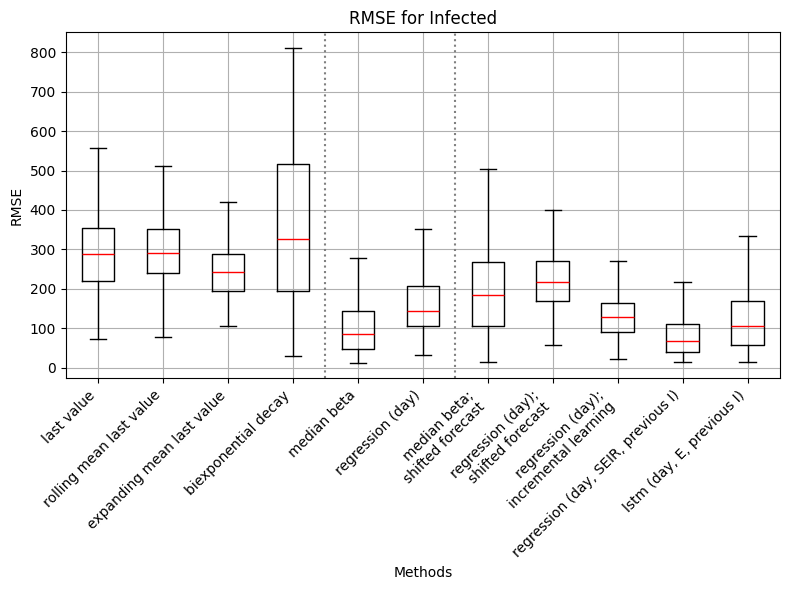

In [19]:
methods = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 
    
    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']
new_labels = ['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay', 
    
    'median_beta',
    'regression_day',

    'median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']

switch = 'type_start_day = roll_var_npeople'

rmse_df = pd.DataFrame()
for beta_prediction_method,new_label in zip(methods, new_labels):
    # loading data from CSV
    df = pd.read_csv(f'results/{switch}/{new_label}_results.csv')
    # add data to DataFrame with the column name as the method
    rmse_df[f"{beta_prediction_method}"] = df['rmse_I']

# creating a boxplot
fig, ax = plt.subplots(1,1,figsize=(8,6))
box = ax.boxplot(rmse_df, showfliers=False, medianprops=dict(color='red'),
                  widths=0.5)

ax.set_title(f'RMSE for Infected')
ax.set_xlabel('Methods')
ax.set_ylabel('RMSE')
ax.set_xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
        labels=methods, rotation=45, ha='right')
ax.axvline(4.5, ls=':', color='gray')
ax.axvline(6.5, ls=':', color='gray')
ax.grid()

plt.tight_layout()
plt.savefig(f'results/{switch}/rmse_I_boxplot.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')    

Median RMSE I for last_value 287.47751781800486
Median RMSE I for rolling_mean_last_value 291.69686717023865
Median RMSE I for expanding_mean_last_value 243.33837868727002
Median RMSE I for biexponential_decay 325.0786076137525
Median RMSE I for median_beta 85.54372723634272
Median RMSE I for regression_day 144.04224621233357
Median RMSE I for median_beta_shifted_forecast 183.61108525010638
Median RMSE I for regression_day_shifted_forecast 217.17908669138922
Median RMSE I for regression_day_incremental_learning 127.99223349323853
Median RMSE I for regression_day_SEIR_previous_I 67.08395395531434
Median RMSE I for lstm_day_E_previous_I 105.102363966535


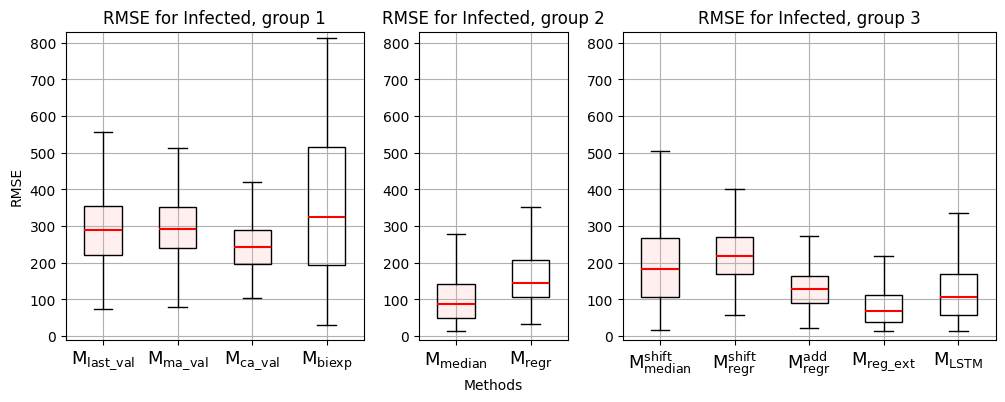

In [6]:
methods = [['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$'], 

    ['$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$'],

    ['$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']]
new_labels = [['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay'], 

    ['median_beta',
    'regression_day'],

    ['median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']]
switch = 'type_start_day = roll_var_npeople'

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[2,1,2.5]) 
for i in range(len(methods)):

    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods[i], new_labels[i]):
        # loading data from CSV
        df = pd.read_csv(f'results/{switch}/{new_label}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_I']
        print(f'Median RMSE I for {new_label}', df['rmse_I'].median())
    
    # creating a boxplot
    ax = plt.subplot(gs[i])
    box = ax.boxplot(rmse_df[methods[i]], showfliers=False, 
                      medianprops=dict(color='red',linewidth=1.5), 
                      widths=0.5, patch_artist=True)
    median_c = (1.0, 0.7, 0.7, 0.2)
    lw=1
    for n, patch in enumerate(box['boxes']):
        if (i == 0) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 1) & (n < 1):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 2) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        else:
            patch.set(fill=False)  
    ax.set_ylim(-10,830)
    ax.set_title(f'RMSE for Infected, group {i+1}')
    if i==1:
        ax.set_xlabel('Methods')
    if i==0:
        ax.set_ylabel('RMSE')
    ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=0, ha='center', fontsize=13)
    ax.grid()  
   
plt.savefig(f'results/{switch}/rmse_I_3.pdf', 
            format='pdf', bbox_inches='tight')

### Boxplot RMSE for Beta for type_start_day = roll_var_npeople


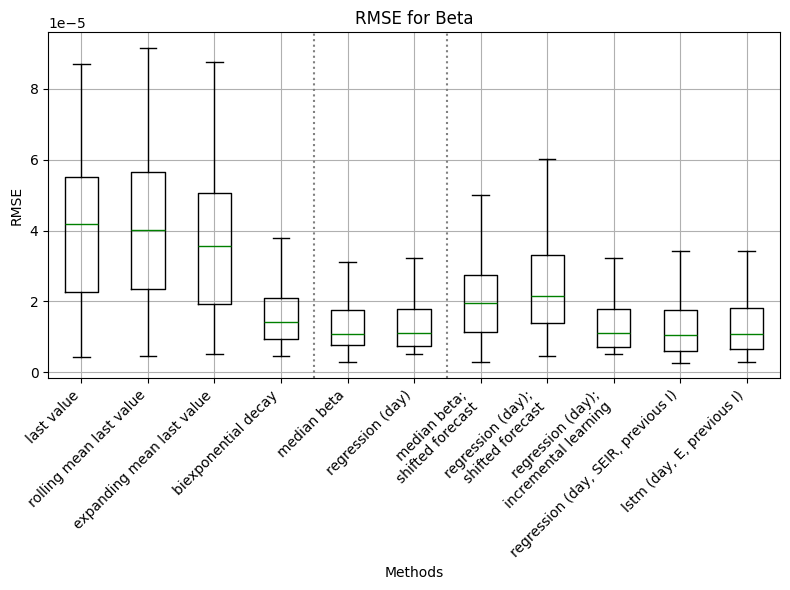

In [22]:
methods = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 
    
    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']
new_labels = ['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay', 
    
    'median_beta',
    'regression_day',

    'median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']

switch = 'type_start_day = roll_var_npeople'

rmse_df = pd.DataFrame()
for beta_prediction_method,new_labels in zip(methods, new_labels):
    # loading data from CSV
    df = pd.read_csv(f'results/{switch}/{new_labels}_results.csv')
    # add data to DataFrame with the column name as the method
    rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']

# creating a boxplot
fig, ax = plt.subplots(1,1,figsize=(8,6))
box = ax.boxplot(rmse_df, showfliers=False, 
                  medianprops=dict(color='green'),widths=0.5)


ax.set_title(f'RMSE for Beta')
ax.set_xlabel('Methods')
ax.set_ylabel('RMSE')
ax.set_xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
        labels=methods, rotation=45, ha='right')
ax.axvline(4.5, ls=':', color='gray')
ax.axvline(6.5, ls=':', color='gray')
ax.grid()

plt.tight_layout()

plt.savefig(f'results/{switch}/rmse_Beta_boxplot.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')    


Median RMSE Beta for last_value 4.1756618469798064e-05
Median RMSE Beta for rolling_mean_last_value 4.027622810365816e-05
Median RMSE Beta for expanding_mean_last_value 3.570753925940745e-05
Median RMSE Beta for biexponential_decay 1.431195044735189e-05
Median RMSE Beta for median_beta 1.0813549523866478e-05
Median RMSE Beta for regression_day 1.119633234040623e-05
Median RMSE Beta for median_beta_shifted_forecast 1.9556298455952146e-05
Median RMSE Beta for regression_day_shifted_forecast 2.1426962682930718e-05
Median RMSE Beta for regression_day_incremental_learning 1.1017140401351344e-05
Median RMSE Beta for regression_day_SEIR_previous_I 1.0489359694495677e-05
Median RMSE Beta for lstm_day_E_previous_I 1.0860319165157629e-05


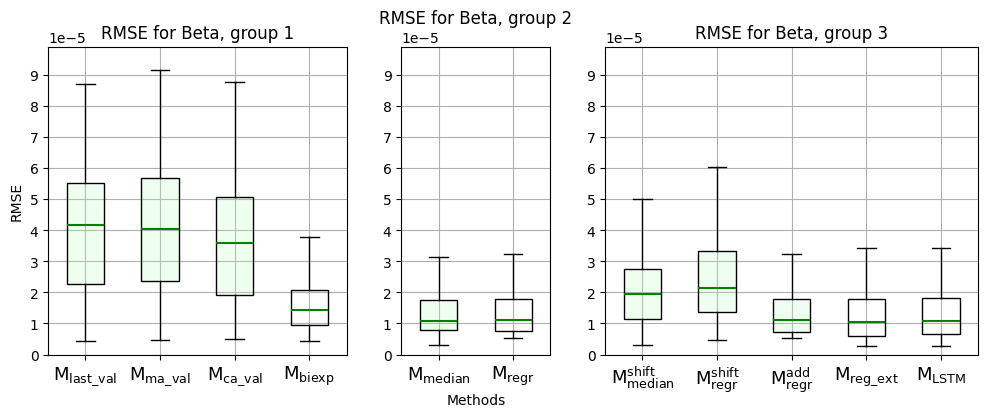

In [12]:
methods = [['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$'], 

    ['$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$'],

    ['$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']]
new_labels = [['last_value',
    'rolling_mean_last_value',
    'expanding_mean_last_value',
    'biexponential_decay'], 

    ['median_beta',
    'regression_day'],

    ['median_beta_shifted_forecast',
    'regression_day_shifted_forecast',
    'regression_day_incremental_learning',
    'regression_day_SEIR_previous_I',       
    'lstm_day_E_previous_I']]

switch = 'type_start_day = roll_var_npeople'

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[4,2,5]) 
for i in range(len(methods)):

    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods[i], new_labels[i]):
        # loading data from CSV
        df = pd.read_csv(f'results/{switch}/{new_label}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']
        print(f'Median RMSE Beta for {new_label}', df['rmse_Beta'].median())

    # creating a boxplot
    ax = plt.subplot(gs[i])
    box = ax.boxplot(rmse_df[methods[i]], showfliers=False, 
                      medianprops=dict(color='green',linewidth=1.5), 
                      widths=0.5, patch_artist=True)
    median_c = (0.7, 1.0, 0.7, 0.2)
    lw=1
    for n, patch in enumerate(box['boxes']):
        if (i == 0) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 1) & (n < 1):
            patch.set(facecolor=median_c, linewidth=lw) 
        elif (i == 2) & (n < 3):
            patch.set(facecolor=median_c, linewidth=lw) 
        else:
            patch.set(fill=False)  
    ax.set_ylim(0,9.9*1e-5)
    ax.set_title(f'RMSE for Beta, group {i+1}')
    if i==1:
        ax.set_xlabel('Methods')
    if i==0:
        ax.set_ylabel('RMSE')
    ax.set_xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=0, ha='center', fontsize=13)
    ax.set_yticks(np.arange(0, 1e-4, 1e-5))
    ax.grid()
    
   
plt.savefig(f'results/{switch}/rmse_Beta_3.pdf', 
            format='pdf', bbox_inches='tight')

### Show peaks plots for type_start_day = roll_var_npeople

In [3]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']

switch = 'type_start_day = roll_var_npeople'

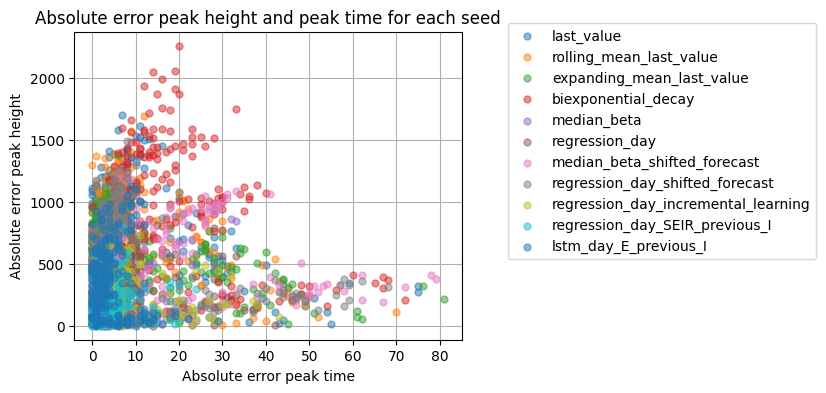

In [25]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
for name in new_labels:
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    
    ax.scatter(abs(p_df['actual_peak_day']-p_df['predicted_peak_day']),
               abs(p_df['actual_peak_I']-p_df['predicted_peak_I']),
               marker='.', s=100,  alpha=0.5, label=name, zorder=3)

ax.grid(True, zorder=0)    
ax.set_title('Absolute error peak height and peak time for each seed')    
ax.set_xlabel('Absolute error peak time')
ax.set_ylabel('Absolute error peak height')
ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.savefig(f'results/{switch}/absolute_error_peaks.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')

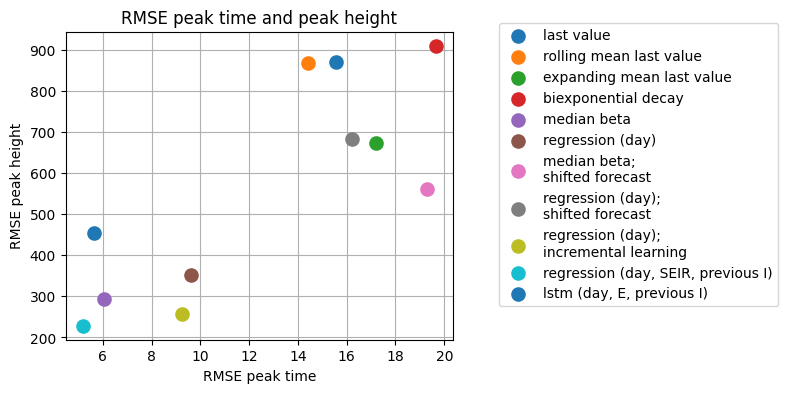

In [26]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
rmse_ph = []
rmse_pt = []
for name in new_labels:
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    rmse_pt.append(rmse(p_df['actual_peak_day'], p_df['predicted_peak_day']))
    rmse_ph.append(rmse(p_df['actual_peak_I'], p_df['predicted_peak_I']))
    
for i, name in enumerate(methods):   
    ax.scatter(rmse_pt[i], rmse_ph[i], marker='o', s=90, label=name, zorder=3)
    
ax.set_title('RMSE peak time and peak height')    
ax.set_xlabel('RMSE peak time')
ax.set_ylabel('RMSE peak height')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.grid(True, zorder=0)    

plt.savefig(f'results/{switch}/rmse_peaks.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')


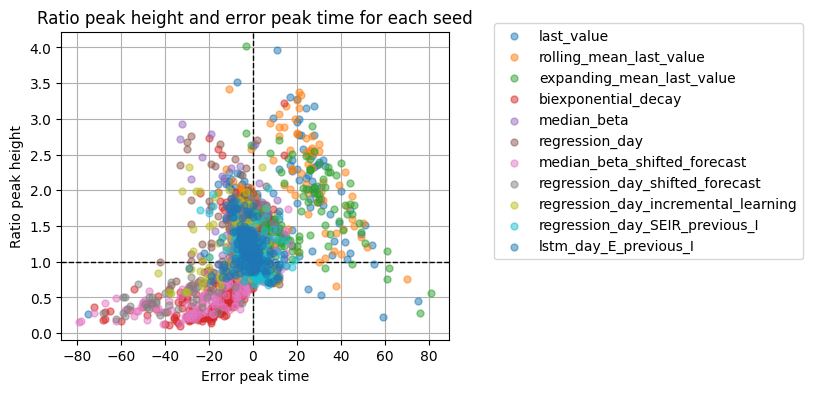

In [27]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

for name in new_labels:
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']  
    
    ax.scatter(pt,ph, marker='.', s=100,  alpha=0.5, label=name, zorder=3)
ax.set_title('Ratio peak height and error peak time for each seed')    
ax.set_xlabel('Error peak time')
ax.set_ylabel('Ratio peak height')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.axvline(x=0, color='black', linestyle='--', linewidth=1, 
           label='Difference of peak time=0')
ax.axhline(y=1, color='black', linestyle='--', linewidth=1, 
           label='Ratio of peak height=1')
ax.grid(True, zorder=0)    

plt.savefig(f'results/{switch}/ratio_and_error_peaks.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')


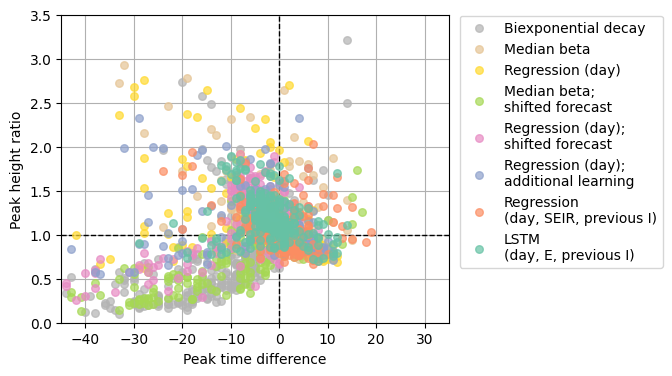

In [28]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', linewidth=1)

methods = ['Biexponential decay', 'Median beta', 'Regression (day)',

            'Median beta;\nshifted forecast',
            'Regression (day);\nshifted forecast',
            'Regression (day);\nadditional learning',
            'Regression\n(day, SEIR, previous I)',       
            'LSTM\n(day, E, previous I)']

new_labels = ['last_value', 'rolling_mean_last_value',
                'expanding_mean_last_value','biexponential_decay', 

                'median_beta','regression_day',

                'median_beta_shifted_forecast','regression_day_shifted_forecast',
                'regression_day_incremental_learning','regression_day_SEIR_previous_I',       
                'lstm_day_E_previous_I']


switch = 'type_start_day = roll_var_npeople'

cmap = mpl.colormaps['Set2']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, 8))
colors = list(colors)

for name, method in zip(new_labels[3:], methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.7, 
               label=method, zorder=10, color=colors.pop())
    
    
#ax.set_title('Ratio peak height and error peak time for each seed')    
ax.set_xlabel('Peak time difference')
ax.set_ylabel('Peak height ratio')
ax.legend(bbox_to_anchor=(1.01, 1.02))
ax.grid()
ax.set_xlim(-45,35)
ax.set_ylim(0,3.5)

plt.savefig(f'results/{switch}/ratio_and_error_peaks_changing_Betas.pdf', 
            format='pdf', bbox_inches='tight')

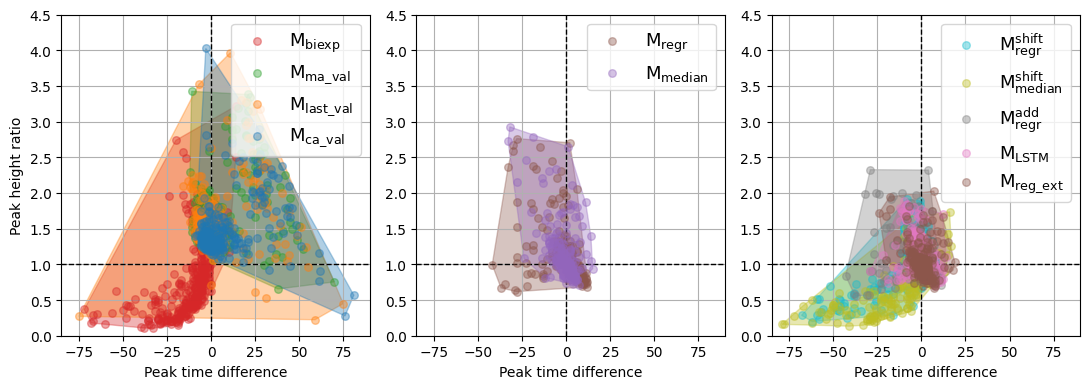

In [77]:
fig, axes = plt.subplots(1,3,figsize=(11, 4))
axes = axes.flatten()

ax = axes[0]
ax.axvline(x=0, color='black', linestyle='--', 
           linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', 
           linewidth=1)

cmap = mpl.colormaps['tab10']
colors = list(cmap.colors[:4])

methods = ['$\mathregular{M_{biexp}}$',
          '$\mathregular{M_{ma\_val}}$',
          '$\mathregular{M_{last\_val}}$',
          '$\mathregular{M_{ca\_val}}$']

new_labels = ['biexponential_decay',
              'rolling_mean_last_value',
              'last_value',
              'expanding_mean_last_value']

switch = 'type_start_day = roll_var_npeople'

for name, method in zip(new_labels, methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    
    hull = ConvexHull(pd.concat([pt,ph], axis=1))
    
    col = colors.pop()
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.4, 
               label=method, zorder=10, color=col)

    ax.fill(pt.iloc[hull.vertices], 
             ph.iloc[hull.vertices], alpha=0.35, color=col)

ax.grid()
ax.set_xlabel('Peak time difference')
ax.set_ylabel('Peak height ratio')
leg = ax.legend(prop={'size': 13}, loc='upper right')
leg.set_zorder(20)
ax.set_xlim(-85,90)
ax.set_ylim(0,4.5)

# ____________

ax = axes[1]
ax.axvline(x=0, color='black', linestyle='--', 
           linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', 
           linewidth=1)

methods = ['$\mathregular{M_{regr}}$',
           '$\mathregular{M_{median}}$']

new_labels = ['regression_day',
              'median_beta']

cmap = mpl.colormaps['tab10']
colors = list(cmap.colors[4:6])
for name, method in zip(new_labels, methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    
    hull = ConvexHull(pd.concat([pt,ph], axis=1))
    
    col = colors.pop()
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.4, 
               label=method, zorder=10, color=col)

    ax.fill(pt.iloc[hull.vertices], 
             ph.iloc[hull.vertices], alpha=0.35, color=col)

ax.grid()
ax.set_xlabel('Peak time difference')
ax.legend(prop={'size': 13}, loc='upper right')
ax.set_xlim(-85,90)
ax.set_ylim(0,4.5)

# ____________

ax = axes[2]
ax.axvline(x=0, color='black', linestyle='--', 
           linewidth=1)
ax.axhline(y=1, color='black', linestyle='--', 
           linewidth=1)

methods = ['$\mathregular{M^{shift}_{regr}}$',
           '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{add}_{regr}}$',
            '$\mathregular{M_{LSTM}}$',
            '$\mathregular{M_{reg\_ext}}$']

new_labels = ['regression_day_shifted_forecast',
              'median_beta_shifted_forecast',
    'regression_day_incremental_learning',
    'lstm_day_E_previous_I',
    'regression_day_SEIR_previous_I']

colors = list(cmap.colors[5:]) + list(cmap.colors[:2])
colors = colors[:5]
for name, method in zip(new_labels, methods):
    p_df = pd.read_csv(f'results/{switch}/{name}_results.csv')
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']
    
    hull = ConvexHull(pd.concat([pt,ph], axis=1))
    
    col = colors.pop()
    ax.scatter(pt,ph, marker='.', s=120,  alpha=.4, 
               label=method, zorder=10, color=col)

    ax.fill(pt.iloc[hull.vertices], 
             ph.iloc[hull.vertices], alpha=0.35, color=col)

ax.grid()
ax.set_xlabel('Peak time difference')
ax.set_xlim(-85,90)
ax.set_ylim(0,4.5)
ax.legend(prop={'size': 13}, loc='upper right')


plt.tight_layout()
plt.savefig(f'results/{switch}/peaks_area.pdf', 
            format='pdf', bbox_inches='tight')

# start day - constant

### Save RMSE Infected и Beta, peaks Infected (hight) and Day (time), predicted time, start day for start day = 20, 30,40.

In [ ]:
seed_numbers = set()
seed_numbers.update(range(int(0), int(300)))
days = np.array([20, 30, 40])
for day in days:
    methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']

    for beta_prediction_method,new_label in zip(methods, new_labels):
        all_rmse_I, all_rmse_Beta, all_peak, execution_time, start_days = main_f('seir', False, 0, beta_prediction_method, day, seed_numbers, False)
        # creating a dataframe for peaks
        all_peak = pd.DataFrame(all_peak, columns=['actual_peak_I', 'predicted_peak_I', 'actual_peak_day', 'predicted_peak_day'])
        # creating a dataframe for RMSE, predicted time, start day
        print(len(all_rmse_I),len(all_rmse_Beta), len(execution_time), len(start_days))
        rmse_df = pd.DataFrame({
            'rmse_I': all_rmse_I,
            'rmse_Beta': all_rmse_Beta,
            'time_predict': execution_time,
            f'{day}': start_days})

        # merging dataframes
        results = pd.concat([rmse_df, all_peak], axis=1)
        results.to_csv(f'results/start_day = {day}/{new_label}_results.csv', index=False)


### Boxplot RMSE for Infected for start_day = 20, 30, 40.


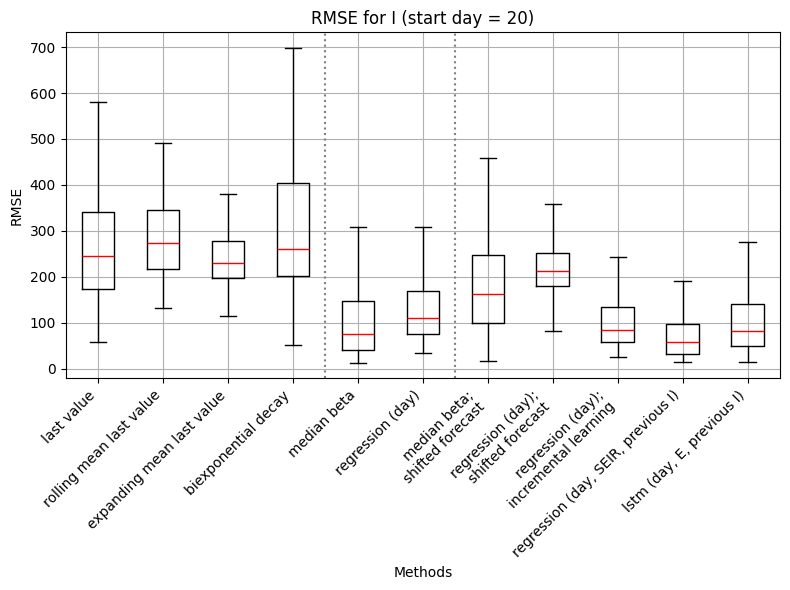

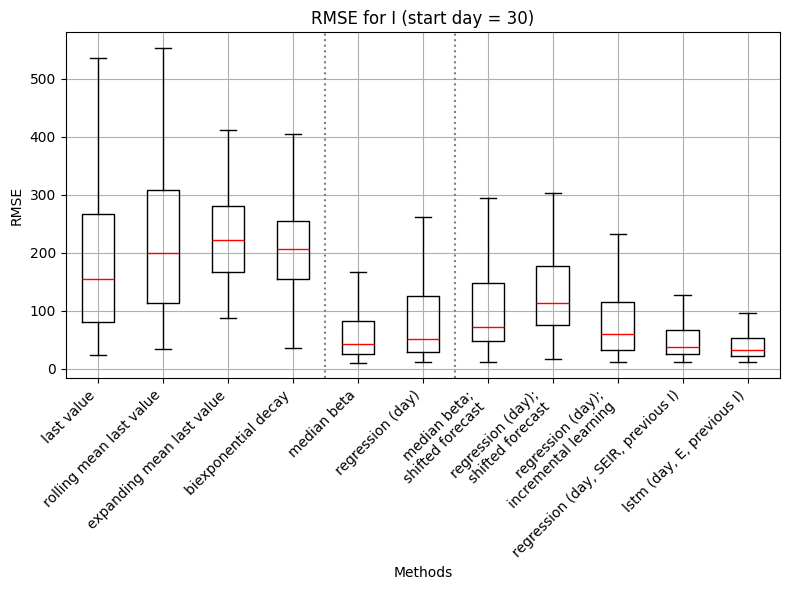

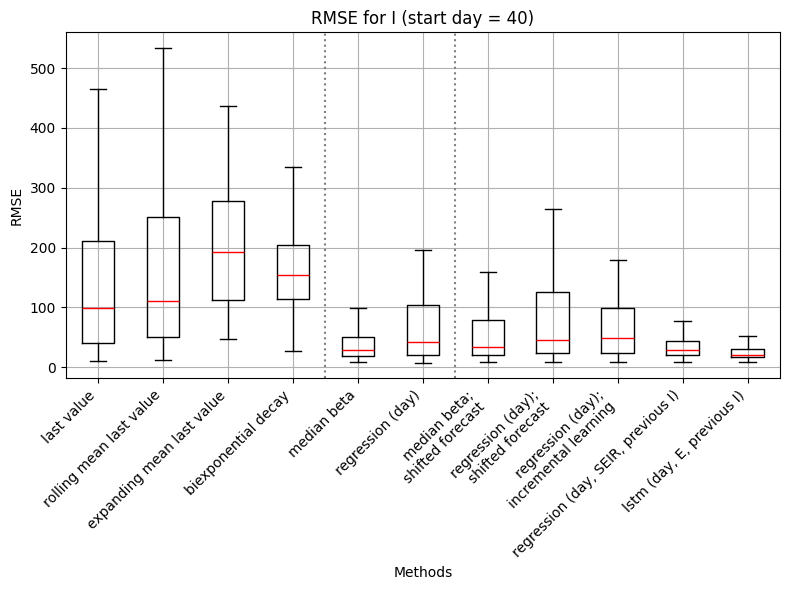

In [30]:
days = np.array([20, 30, 40])
for day in days:
    methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',      
        'lstm (day, E, previous I)']
    new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']
    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods, new_labels):
        # loading data from CSV
        df = pd.read_csv(f'results/start_day = {day}/{new_label}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_I']

    # creating a boxplot
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    box = ax.boxplot(rmse_df, showfliers=False, medianprops=dict(color='red'),
                      widths=0.5)

    ax.set_title(f'RMSE for I (start day = {day})')
    ax.set_xlabel('Methods')
    ax.set_ylabel('RMSE')
    ax.set_xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')
    ax.axvline(4.5, ls=':', color='gray')
    ax.axvline(6.5, ls=':', color='gray')
    ax.grid()

    plt.tight_layout()
    plt.savefig(f'results/start_day = {day}/rmse_I_boxplot.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')    

### Boxplot RMSE for Beta for start_day = 20, 30, 40.

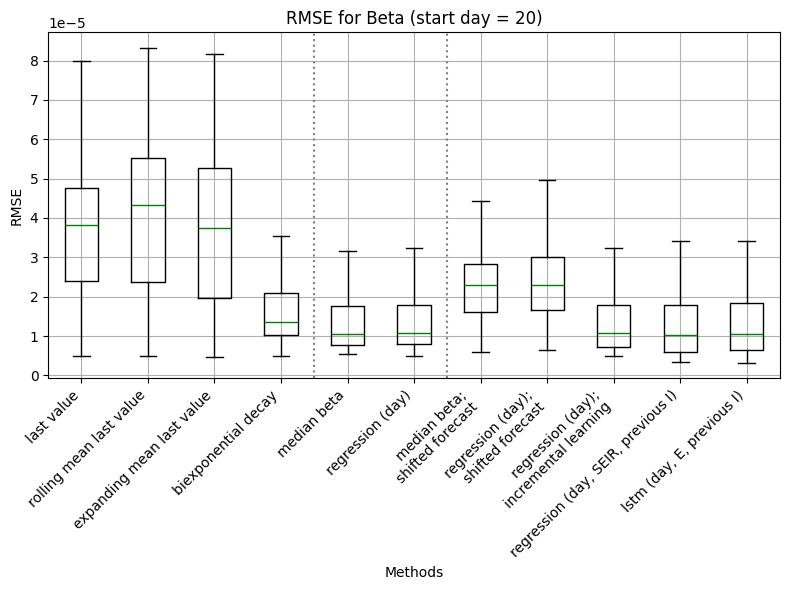

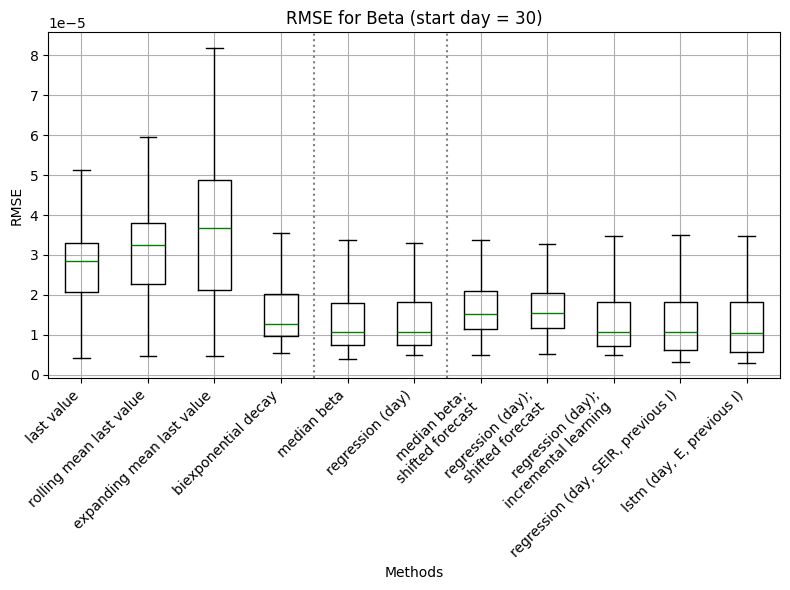

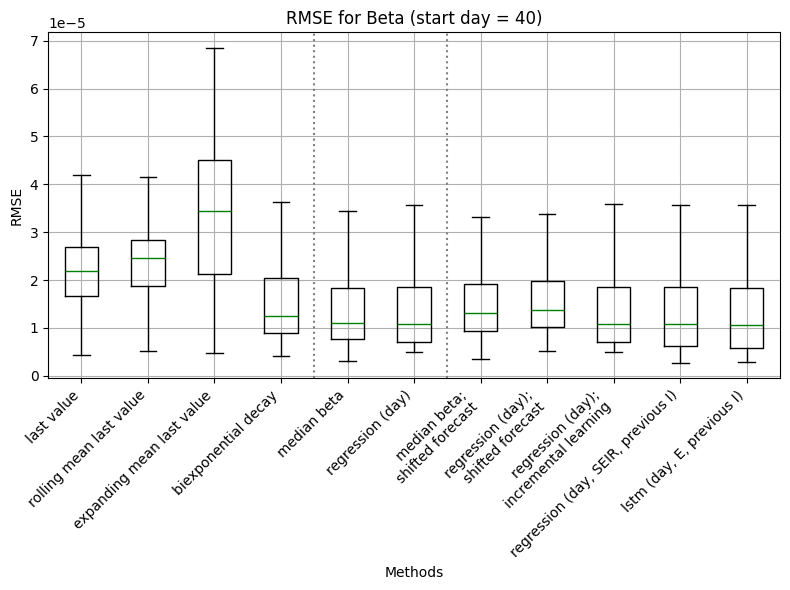

In [31]:
days = np.array([20, 30, 40])
for day in days:
    methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']
    rmse_df = pd.DataFrame()
    for beta_prediction_method,new_label in zip(methods, new_labels):
        # loading data from CSV
        df = pd.read_csv(f'results/start_day = {day}/{new_label}_results.csv')
        # add data to DataFrame with the column name as the method
        rmse_df[f"{beta_prediction_method}"] = df['rmse_Beta']

    # creating a boxplot
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    box = ax.boxplot(rmse_df, showfliers=False, medianprops=dict(color='green'),
                      widths=0.5)

    ax.set_title(f'RMSE for Beta (start day = {day})')
    ax.set_xlabel('Methods')
    ax.set_ylabel('RMSE')
    ax.set_xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')
    ax.axvline(4.5, ls=':', color='gray')
    ax.axvline(6.5, ls=':', color='gray')
    ax.grid()

    plt.tight_layout()
    plt.savefig(f'results/start_day = {day}/rmse_Beta_boxplot.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')    

### Show peaks plots for start_day = 30.

In [32]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I']
day = 30

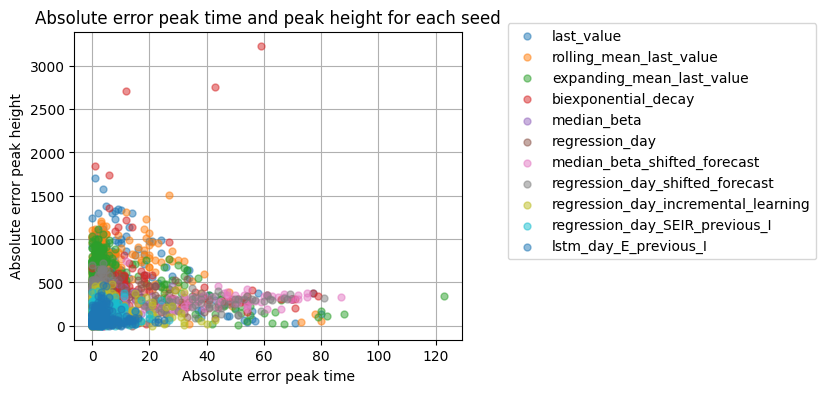

In [33]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
for name in new_labels:
    p_df = pd.read_csv(f'results/start_day = {day}/{name}_results.csv')
    
    ax.scatter(abs(p_df['actual_peak_day']-p_df['predicted_peak_day']),
               abs(p_df['actual_peak_I']-p_df['predicted_peak_I']),
               marker='.', s=100,  alpha=0.5, label=name, zorder=3)
    
ax.set_title('Absolute error peak time and peak height for each seed')    
ax.set_xlabel('Absolute error peak time')
ax.set_ylabel('Absolute error peak height')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.grid(True, zorder=1)

plt.savefig(f'results/start_day = {day}/absolute_error_peaks.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')

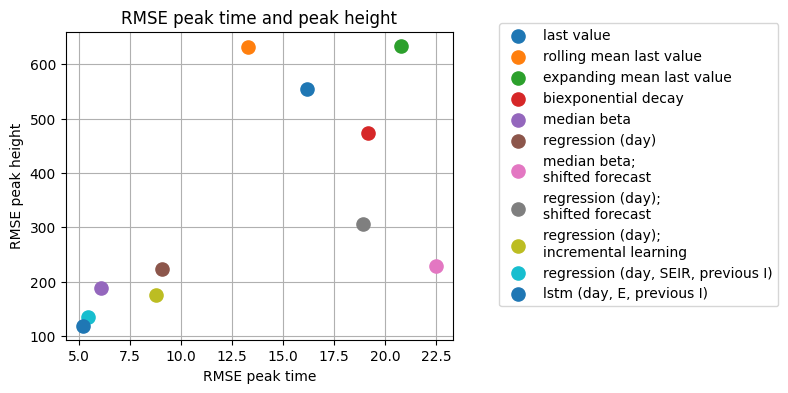

In [34]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
rmse_ph = []
rmse_pt = []
for name in new_labels:
    p_df = pd.read_csv(f'results/start_day = {day}/{name}_results.csv')
    rmse_pt.append(rmse(p_df.iloc[:]['actual_peak_day'], 
                        p_df.iloc[:]['predicted_peak_day']))
    rmse_ph.append(rmse(p_df.iloc[:]['actual_peak_I'], 
                        p_df.iloc[:]['predicted_peak_I']))
    
    
for i, name in enumerate(methods):   
    ax.scatter(rmse_pt[i], rmse_ph[i], marker='o', s=90, label=name, zorder=3)
    
ax.set_title('RMSE peak time and peak height')    
ax.set_xlabel('RMSE peak time')
ax.set_ylabel('RMSE peak height')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.grid(True, zorder=1)

plt.savefig(f'results/start_day = {day}/rmse_peaks.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')


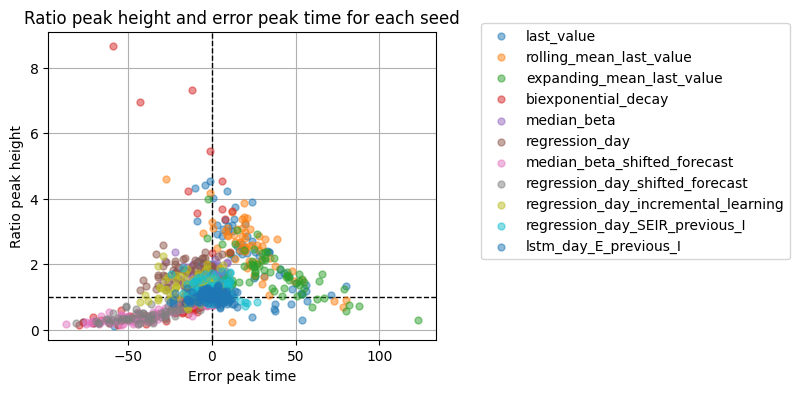

In [35]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

for name in new_labels:
    p_df = pd.read_csv(f'results/start_day = {day}/{name}_results.csv')
    pt = p_df['predicted_peak_day'] - p_df['actual_peak_day']
    ph = p_df['predicted_peak_I']/p_df['actual_peak_I']  
    
    ax.scatter(pt,ph, marker='.', s=100,  alpha=0.5, label=name, zorder=3)
ax.set_title('Ratio peak height and error peak time for each seed')    
ax.set_xlabel('Error peak time')
ax.set_ylabel('Ratio peak height')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.axvline(x=0, color='black', linestyle='--', linewidth=1, 
           label='Difference of peak time=0')
ax.axhline(y=1, color='black', linestyle='--', linewidth=1, 
           label='Ratio of peak height=1')
ax.grid(True, zorder=0)    

plt.savefig(f'results/start_day = {day}/ratio_and_error_peaks.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')


### Beta-trajectories and Predicted I-trajectories for several constant Beta and start day = 30.

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

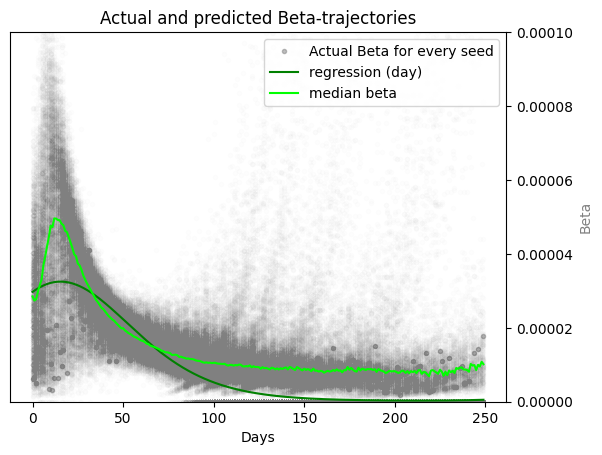

In [39]:
fig, ax = plt.subplots()
for i in np.arange(0,960):
    df = pd.read_csv(f'train/seir_seed_{i}.csv')
    if i ==0:
        lab = 'Actual Beta for every seed'
        ax.plot(np.arange(0,250), df['Beta'].values, marker='.', ls='', alpha=0.5, color = 'gray', label = lab)
    else:
        lab = ''
        ax.plot(np.arange(0,250), df['Beta'].values,marker='.', ls='', alpha=0.01, color = 'gray', label = lab)
sigma = 0.1
gamma = 0.08
beggining_beta, predicted_beta, predicted_I = predict_Beta_I.predict_beta(
                            'seir', df, 'regression (day)', 
                             np.arange(30, df.shape[0]), False, 0, sigma, gamma,
                             features_reg = ['day','prev_I','S','E','I','R'])

ax.plot(np.arange(0,250), np.concatenate((beggining_beta, predicted_beta)) , color = 'green', label ='regression (day)')
df = pd.read_csv(f'train/median_beta.csv')    
ax.plot(np.arange(0,250), df['median_beta'].values, ls='-', color = '#00FF00', label = 'median beta')

ax.set_ylim(0,1e-4)
ax.set_xlabel("Days")
ax.set_ylabel("Beta", color='gray')
ax.legend(loc='upper right')
ax.set_title('Actual and predicted Beta-trajectories')
ax.yaxis.tick_right() 
ax.yaxis.set_label_position("right")

plt.tight_layout
#plt.savefig(f'results/Beta_trajectories.pdf', 
#            format='pdf',  bbox_inches='tight')   


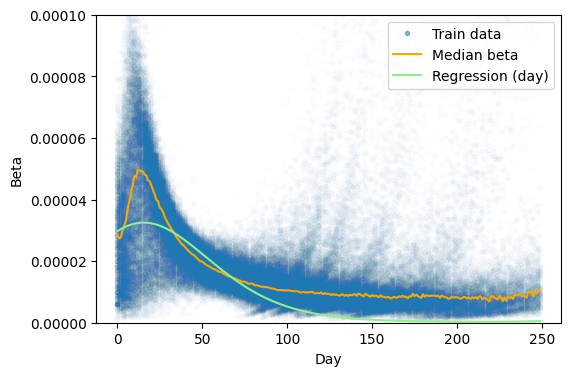

In [ ]:
all_betas = pd.DataFrame()
for i in np.arange(960):
    df = pd.read_csv(f'train/seir_seed_{i}.csv')
    epidemic_end = df[(df['E'] == 0) & (df['I'] == 0)].index
    if epidemic_end.shape[0]>1:
        df['Beta'].loc[epidemic_end[1]:] = -2
    all_betas = pd.concat([all_betas, df[['Beta']]], axis=1)


fig = plt.figure(figsize=(6, 4)) 
plt.plot(all_betas.iloc[0,0], marker='.', ls='',alpha=0.5,
        label='Train data')
plt.plot(all_betas[all_betas>0], marker='.', ls='',alpha=0.01,
        color='tab:blue');
plt.plot(all_betas[all_betas>0].median(axis=1), ls='-', color='orange', 
         label='$\mathregular{M_{median}}$')

sigma = 0.1
gamma = 0.08
beggining_beta, predicted_beta, predicted_I = predict_Beta_I.predict_beta(
                            'seir', df, 'regression (day)', 
                             np.arange(30, df.shape[0]), False, 0, sigma, gamma,
                             features_reg = ['day','prev_I','S','E','I','R'])

plt.plot(df.index.values, 
         np.concatenate((beggining_beta, predicted_beta)), ls='-', color='lightgreen', 
         label='$\mathregular{M_{regr}}$')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Beta')
plt.ylim(0,1e-4)
plt.legend()
plt.savefig(f'results/Beta_trajectories.pdf', 
            format='pdf',  bbox_inches='tight') 

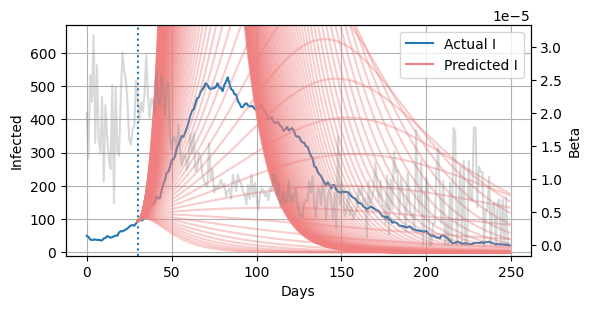

In [3]:

betas = np.arange(0, 1e-4, 1e-6)
start_day = 30
seed_number = 3
seed_df = pd.read_csv(f'test/seir_seed_{seed_number}.csv')

fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.plot(seed_df.index, seed_df['I'].values , color='tab:blue', 
                label='Actual I')

ax_b = ax.twinx()
ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='-', 
                  alpha=0.3, label='Beta')
ax.axvline(start_day, ls=':')

y = seed_df.iloc[start_day, :4].values
predicted_days = np.arange(start_day, seed_df.shape[0])
for beta in betas:
    if beta == 0:
        label='Predicted I'
    else:
        label=''
    S,E,I,R = predict_Beta_I.predict_I('seir',y, predicted_days, beta, 
                                       0.1, 0.08, stype='d', beta_t=False)
    ax.plot(np.arange(start_day, seed_df.shape[0]), I, 
            color='lightcoral', alpha=0.4, label=label)
    
ll = ax.legend()
for lh in ll.legend_handles:
    lh.set_alpha(1)
ax.set_xlabel('Days')
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
#ax.set_ylabel('Infected',color='tab:blue')
#ax_b.set_ylabel('Beta',color='gray')
#ax.set_title('Predicted I-trajectories for several constant Beta ')
ax.set_ylim(-10, seed_df.I.max()*1.3)
ax.grid()

plt.savefig(f'results/start_day = {start_day}/several_constant_Beta.pdf',  
            format='pdf', bbox_inches='tight')

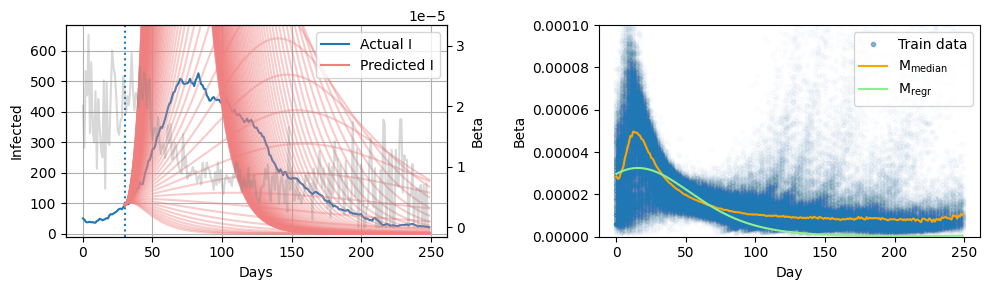

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.flatten()

ax= axes[0]
betas = np.arange(0, 1e-4, 1e-6)
start_day = 30
seed_number = 3
seed_df = pd.read_csv(f'test/seir_seed_{seed_number}.csv')
ax.plot(seed_df.index, seed_df['I'].values , color='tab:blue', 
                label='Actual I')

ax_b = ax.twinx()
ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='-', 
                  alpha=0.3, label='Beta')
ax.axvline(start_day, ls=':')

y = seed_df.iloc[start_day, :4].values
predicted_days = np.arange(start_day, seed_df.shape[0])
for beta in betas:
    if beta == 0:
        label='Predicted I'
    else:
        label=''
    S,E,I,R = predict_Beta_I.predict_I('seir',y, predicted_days, beta, 
                                       0.1, 0.08, stype='d', beta_t=False)
    ax.plot(np.arange(start_day, seed_df.shape[0]), I, 
            color='lightcoral', alpha=0.4, label=label)
    
ll = ax.legend()
for lh in ll.legend_handles:
    lh.set_alpha(1)
ax.set_xlabel('Days')
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_ylim(-10, seed_df.I.max()*1.3)
ax.grid()

ax = axes[1]

all_betas = pd.DataFrame()
for i in np.arange(960):
    df = pd.read_csv(f'train/seir_seed_{i}.csv')
    epidemic_end = df[(df['E'] == 0) & (df['I'] == 0)].index
    if epidemic_end.shape[0]>1:
        df['Beta'].loc[epidemic_end[1]:] = -2
    all_betas = pd.concat([all_betas, df[['Beta']]], axis=1)

ax.plot(all_betas.iloc[0,0], marker='.', ls='',alpha=0.5,
        label='Train data')
ax.plot(all_betas[all_betas>0], marker='.', ls='',alpha=0.01,
        color='tab:blue');
ax.plot(all_betas[all_betas>0].median(axis=1), ls='-', color='orange', 
         label='$\mathregular{M_{median}}$')

sigma = 0.1
gamma = 0.08
beggining_beta, predicted_beta, predicted_I = predict_Beta_I.predict_beta(
                            'seir', df, 'regression (day)', 
                             np.arange(30, df.shape[0]), False, 0, sigma, gamma,
                             features_reg = ['day','prev_I','S','E','I','R'])

ax.plot(df.index.values, 
         np.concatenate((beggining_beta, predicted_beta)), ls='-', color='lightgreen', 
         label='$\mathregular{M_{regr}}$')
ax.legend()
ax.set_xlabel('Day')
ax.set_ylabel('Beta')
ax.set_ylim(0,1e-4)

fig.tight_layout()
plt.savefig(f'results/start_day = {start_day}/const_and_regr.png', format='png', bbox_inches='tight', dpi=300)

### 5 seed graphs for beta_prediction_method groups with start_day = 30.

group 1

In [18]:
start_day = 30
seed = 3

last value
3
rolling mean last value
3
expanding mean last value
3
biexponential decay
3


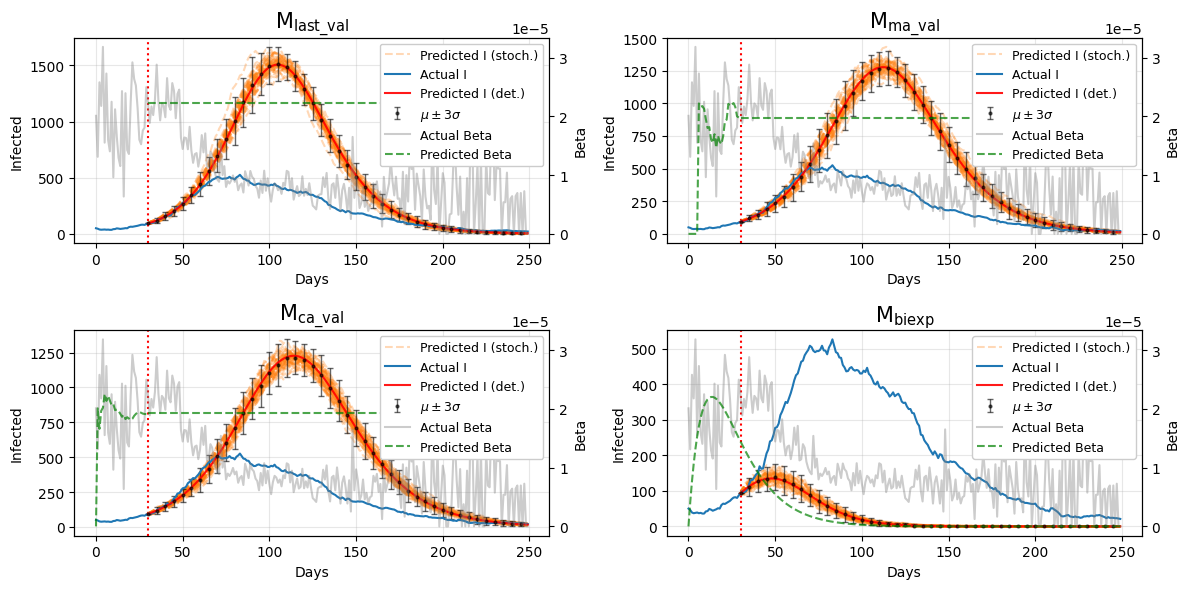

In [28]:
methods = ['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$', 

    '$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$',

    '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']
new_labels = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 

    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']

count_stoch_line = 50
seeds = set()
seeds.update(range(int(seed), int(seed+1)))
seed_number = next(iter(seeds))
seed_df = pd.read_csv(f'test/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(2,2, figsize=(12,6))
axes=ax.flatten()
n = 4

for beta_prediction_method, label, i in zip(new_labels[:n], methods[:n], range(n)):
    seed_number = seeds   
    main_f('seir', True, count_stoch_line, 
                           beta_prediction_method, start_day, seed_number, False, axes[i])
    
    axes[i].set_title(f"{label}",size=15)

plt.tight_layout()  
plt.savefig(f'results/start_day = {start_day}/3sigma_group1.pdf',  
            format='pdf', bbox_inches='tight')

group 2

median beta
3
regression (day)
3


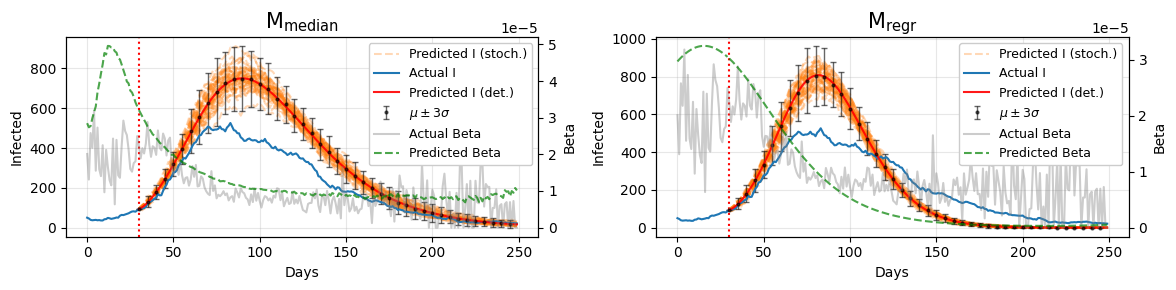

In [29]:

methods = ['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$', 

    '$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$',

    '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']
new_labels = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 

    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']

count_stoch_line = 50
seeds = set()
seeds.update(range(int(seed), int(seed+1)))
seed_number = next(iter(seeds))
seed_df = pd.read_csv(f'test/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]
n = 2
fig, ax = plt.subplots(1,2, figsize=(12,3))
axes=ax.flatten()



for beta_prediction_method, label, i in zip(new_labels[4:6], methods[4:6], range(n)):
    seed_number = seeds
    main_f('seir', True, count_stoch_line, 
                           beta_prediction_method, start_day, seed_number, False, axes[i])
    
    axes[i].set_title(f"{label}",size=15)

plt.tight_layout()  
plt.savefig(f'results/start_day = {start_day}/3sigma_group2.pdf',  
            format='pdf', bbox_inches='tight')

group 3

median beta;
shifted forecast
3
regression (day);
shifted forecast
3
regression (day);
incremental learning
3
regression (day, SEIR, previous I)
3
lstm (day, E, previous I)
3


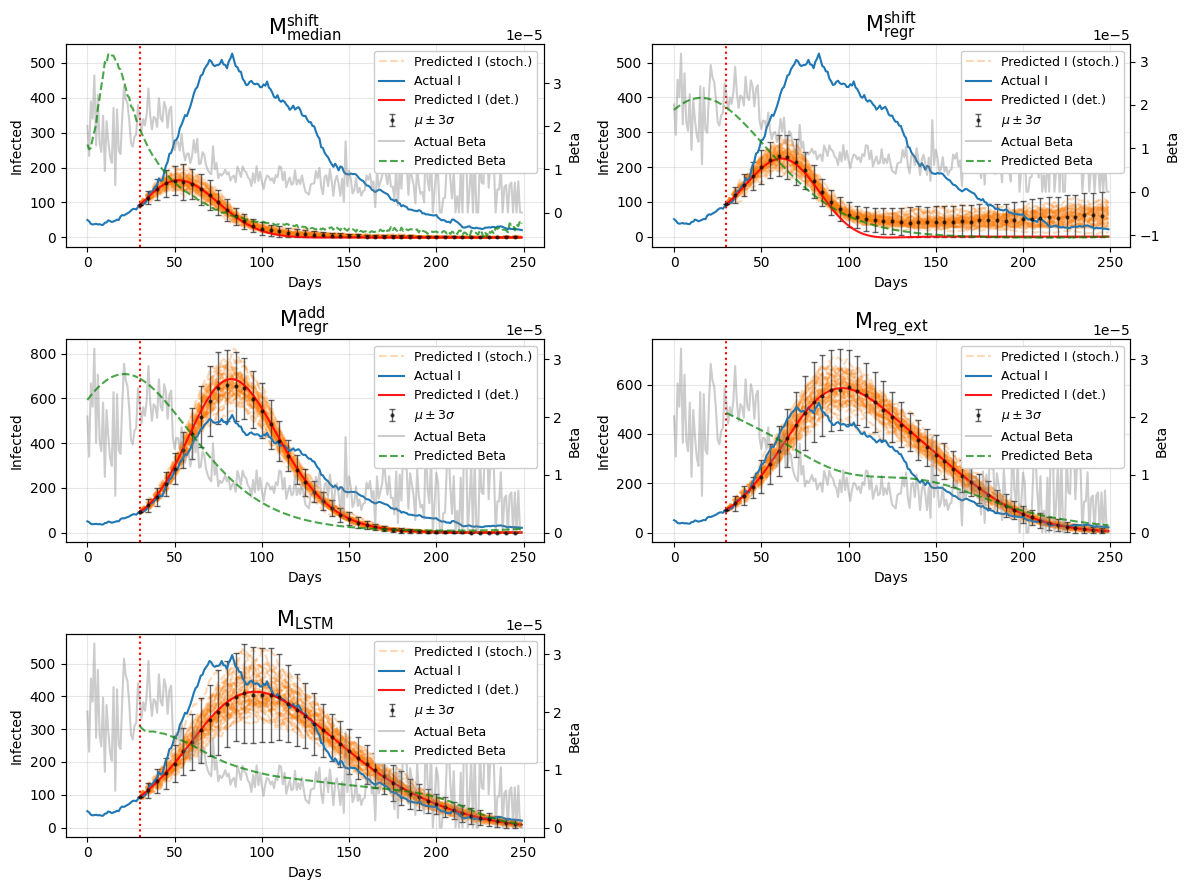

In [30]:

methods = ['$\mathregular{M_{last\_val}}$',
    '$\mathregular{M_{ma\_val}}$',
    '$\mathregular{M_{ca\_val}}$',
    '$\mathregular{M_{biexp}}$', 

    '$\mathregular{M_{median}}$',
    '$\mathregular{M_{regr}}$',

    '$\mathregular{M^{shift}_{median}}$',
            '$\mathregular{M^{shift}_{regr}}$',
            '$\mathregular{M^{add}_{regr}}$',
    '$\mathregular{M_{reg\_ext}}$',       
    '$\mathregular{M_{LSTM}}$']
new_labels = ['last value',
    'rolling mean last value',
    'expanding mean last value',
    'biexponential decay', 

    'median beta',
    'regression (day)',

    'median beta;\nshifted forecast',
    'regression (day);\nshifted forecast',
    'regression (day);\nincremental learning',
    'regression (day, SEIR, previous I)',       
    'lstm (day, E, previous I)']

n_s = 50
seeds = set()
seeds.update(range(int(seed), int(seed+1)))
seed_number = next(iter(seeds))
seed_df = pd.read_csv(f'test/seir_seed_{seed_number}.csv')
seed_df = seed_df[pd.notna(seed_df['Beta'])]

fig, ax = plt.subplots(3,2, figsize=(12,9))
axes=ax.flatten()

n = 6

for beta_method, label, i in zip(new_labels[6:], methods[6:], range(n)):
    seed_number = seeds
    main_f('seir', True, n_s, 
                           beta_method, start_day, seed_number, False, axes[i])
    
    axes[i].set_title(f"{label}",size=15)

fig.delaxes(axes[-1])   
plt.tight_layout()  
plt.savefig(f'results/start_day = {start_day}/3sigma_group3.pdf',  
            format='pdf', bbox_inches='tight')

# boxplot difference between the day of the switch and the peak.

Median values for each type of switch day:
$\mathregular{SP_{once}}$        38.0
$\mathregular{SP_{establ}}$      37.0
$\mathregular{SP_{epi\_sit}}$    40.0
$\mathregular{SP_{20}}$          36.0
$\mathregular{SP_{30}}$          26.0
$\mathregular{SP_{40}}$          16.0
dtype: float64

Min values for each type of switch day:
$\mathregular{SP_{once}}$        10
$\mathregular{SP_{establ}}$      10
$\mathregular{SP_{epi\_sit}}$    13
$\mathregular{SP_{20}}$          19
$\mathregular{SP_{30}}$           9
$\mathregular{SP_{40}}$          -1
dtype: int64


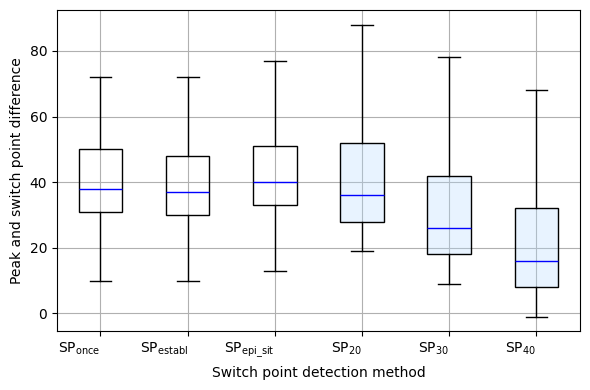

In [32]:
types_start_day = ['roll_var','roll_var_seq','roll_var_npeople']
titles_start_day1 =  ['$\mathregular{SP_{once}}$', 
                    '$\mathregular{SP_{establ}}$', 
                    '$\mathregular{SP_{epi\_sit}}$']
titles_start_day2 =  ['$\mathregular{SP_{20}}$', 
                    '$\mathregular{SP_{30}}$', 
                    '$\mathregular{SP_{40}}$']
days = np.array([20, 30, 40])
difference_df = pd.DataFrame()
for type_start_day, title_start_day in zip(types_start_day, titles_start_day1):
    # loading data from CSV
    df = pd.read_csv(f'results/type_start_day = {type_start_day}/last_value_results.csv')
    # add data to DataFrame with the column name as the method
    difference_df[f"{title_start_day}"] = df[f'actual_peak_day'] - df[f'{type_start_day}']
for day, title_start_day in zip(days, titles_start_day2):
    # loading data from CSV
    df = pd.read_csv(f'results/start_day = {day}/last_value_results.csv')
    # add data to DataFrame with the column name as the method
    difference_df[f"{title_start_day}"] = df[f'actual_peak_day'] - df[f'{day}']

# creating a boxplot
fig, ax = plt.subplots(1,1,figsize=(6,4))
box = ax.boxplot(
    difference_df,
    showfliers=False,
    medianprops=dict(color='blue'),
    widths=0.5,
    patch_artist=True  # <-- ВАЖНО!
)

median_c = (0.7, 0.85, 1.0, 0.3)
lw = 1
for n, patch in enumerate(box['boxes']):
    if n in [3, 4, 5]:  # 4-й, 5-й, 6-й боксы — подсветить
        patch.set_facecolor(median_c)
    else:  # Остальные — без заливки
        patch.set_facecolor('none')
    patch.set_linewidth(lw)


#ax.set_title(f'Difference between the day of the switch and the peak')
ax.set_xlabel('Switch point detection method')
ax.set_ylabel('Peak and switch point difference')
ax.set_xticks(ticks=np.arange(1, difference_df.shape[1]+1), 
        labels=difference_df.columns, ha='right')
ax.grid()

plt.tight_layout()
plt.savefig(f'results/diffenerce_switch_peak.pdf', 
           format='pdf', dpi=300, bbox_inches='tight')    

median_values = difference_df.median()
min_values = difference_df.min()

print("Median values for each type of switch day:")
print(median_values)

print("\nMin values for each type of switch day:")
print(min_values)

# pivot tables for all models and switches

In [14]:
# save by switch method

new_labels = ['last_value', 'rolling_mean_last_value',
                'expanding_mean_last_value','biexponential_decay', 

                'median_beta','regression_day',

                'median_beta_shifted_forecast','regression_day_shifted_forecast',
                'regression_day_incremental_learning','regression_day_SEIR_previous_I',       
                'lstm_day_E_previous_I']


switches = [f'start_day = {n}' for n in [20, 30, 40]] + \
            [f'type_start_day = {i}' for i in ['roll_var_npeople', 'norm_var', 'roll_var', 'roll_var_seq']]

for switch in switches:
    fin = pd.DataFrame([])
    
    clm_with_switch = switch.split(' = ')[-1]
    clms = ['rmse_I', 'rmse_Beta', 'time_predict', clm_with_switch]
    for m in new_labels:
        df = pd.read_csv(f'results/{switch}/{m}_results.csv')

        q = df[clms].apply(lambda x: [x.median(), x.std()]).T
        pt = df['predicted_peak_day'] - df['actual_peak_day']
        q.loc['pt_diff'] = pt.median(), pt.std()
        ph = df['predicted_peak_I']/df['actual_peak_I']
        q.loc['ph_fraq'] = ph.median(), ph.std()
        q.columns = [[m + '_mean', m + '_std']]
        fin = pd.concat([fin, q], axis=1)
        
    fin.to_csv(f'results/pivot_tables/{clm_with_switch}_pivot.csv')

# switches for 30 and 71 seed


 start day = 14 for seed = 30 and type start day = roll_var
 start day = 36 for seed = 30 and type start day = roll_var_seq
 start day = 28 for seed = 30 and type start day = roll_var_npeople
 start day = 24 for seed = 71 and type start day = roll_var
 start day = 32 for seed = 71 and type start day = roll_var_seq
 start day = 24 for seed = 71 and type start day = roll_var_npeople


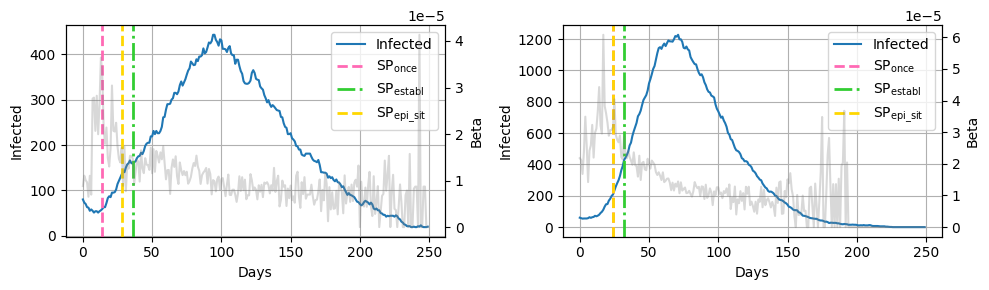

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax = ax.flatten()

for i,seed_number in enumerate([30,71]):
    seed_df = pd.read_csv(f'test/seir_seed_{seed_number}.csv')
    seed_df = seed_df[pd.notna(seed_df['Beta'])]

    # displaying the actual Infected values
    ax[i].plot(seed_df.index, seed_df['I'].values , color='tab:blue', 
                label='Infected')
    ax_b = ax[i].twinx()
    # displaying the actual Beta values
    ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='-', 
                  alpha=0.3, label='Beta')
    ax[i].grid()
    colors=['gold','limegreen','hotpink']
    lss=['--','-.','--']
    for sm, lab in zip(['roll_var','roll_var_seq','roll_var_npeople'],
                        ['$\mathregular{SP_{once}}$', 
                         '$\mathregular{SP_{establ}}$', 
                         '$\mathregular{SP_{epi\_sit}}$']):
        c = colors.pop()
        start_day = choice_start_day.choose_method(seed_df, sm)
        ax[i].axvline(start_day, color=c, alpha=1, 
                   lw=2, label=lab, ls=lss.pop())
        print(f' start day = {start_day} for seed = {seed_number} and type start day = {sm}')

    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Infected')
    ax_b.set_ylabel('Beta')
    ax[i].legend(loc='upper right')
    
plt.tight_layout()
plt.savefig(f'results/12_and_29_seeds_switches.pdf',  
            format='pdf', bbox_inches='tight')

# Код графического окна

In [ ]:
'''
Create a graphical window for parameter input
'''
def parse_seeds(seeds_input):
    ''' 
    Parse and sort numbers of seeds
    '''

    # Use a set to store unique values
    seeds = set()  
   
    parts = seeds_input.split(',') 
    for part in parts:
        if '-' in part:  # Detect range by hyphen
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # Add numbers from range
        else:
            seeds.add(int(part))  # Add individual seed numbers
            
    return sorted(seeds)

def calculate():
    try:
        # Get values from input fields
        I_prediction_method = var_I_prediction_method.get()
        stochastic = var_stochastic.get()
        # Get the number of stochastic trajectories if stochastic mode is enabled
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0  
        beta_prediction_method = var_beta_prediction_method.get()
        # Get the start day value
        start_day = selected_start_day.get()

        # Convert start day value to an integer if it's '20', '30' or '40'
        if start_day in ['20','30','40']:
            start_day = int(start_day)

        seed_numbers = entry_seed_numbers.get()
        # Parse and sort numbers of seeds
        seed_numbers = parse_seeds(seed_numbers)
        
        # Call the main function
        result = main_f(I_prediction_method, stochastic, count_stoch_line, 
                        beta_prediction_method, start_day, seed_numbers,
                        True)
        
        # Display result
        messagebox.showinfo("Result", "Completed")
    except ValueError:
        messagebox.showerror("Error", "Please enter valid data.")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")

# Create main window
root = tk.Tk()
root.title("Parameter Input")

# Create variable for selecting prediction model
var_I_prediction_method = tk.StringVar(value="seir")  # Set default value
# Create dropdown menu for selecting prediction model
label_I_prediction_method = tk.Label(root, text="Infected Prediction Method:")
label_I_prediction_method.pack()
I_prediction_method_options = ["seir"]
dropdown_I_prediction_method = tk.OptionMenu(root, var_I_prediction_method, 
                                             *I_prediction_method_options)
dropdown_I_prediction_method.pack()

# Create checkbox for stochastic mode
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Stochastic", 
                                     variable=var_stochastic, 
                                     command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# Create label and input field for the number of stochastic trajectories
label_count_stoch_line = tk.Label(root, text="Number of Stochastic Trajectories:")
label_count_stoch_line.pack()
entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # Initially disable input field

# Function to enable/disable input field based on checkbox state
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # Enable input field
    else:
        entry_count_stoch_line.config(state='disabled')  # Disable input field

# Create variable for selecting beta prediction method
var_beta_prediction_method = tk.StringVar(value="last value")  # Set default value
# Create dropdown menu for selecting beta prediction method
label_beta_prediction_method = tk.Label(root, text="Beta Prediction Method:")
label_beta_prediction_method.pack()
beta_prediction_method_options =  ['last_value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        'median beta',
        'regression (day)',
        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
dropdown_beta_prediction_method = tk.OptionMenu(root, var_beta_prediction_method, 
                                                *beta_prediction_method_options)
dropdown_beta_prediction_method.pack()

# Create label for start day type
# Variable for selecting start day type
selected_start_day = tk.StringVar(value='30')

# Create dropdown menu for selecting start day type
label_start_day = tk.Label(root, text="Start Day Calculation Type:")
label_start_day.pack()

start_day_options = ['roll_var', 
                     'roll_var_seq', 
                     'roll_var_npeople', 
                     '20',
                     '30',
                     '40']
dropdown_start_day = tk.OptionMenu(root, selected_start_day, *start_day_options)
dropdown_start_day.pack()

# Create label and input field for seed numbers
label_seed_numbers = tk.Label(root, 
                              text="Seed Numbers (comma-separated or range with hyphen):")
label_seed_numbers.pack()
entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# Create button to execute calculation
button_calculate = tk.Button(root, text="Calculate", command=calculate)
button_calculate.pack() 

# Run the main application loop
root.mainloop()
